# Combinatorial Optimization with Physics-Inspired Graph Neural Networks

In this notebook we show how to solve combinatorial optimization problems with physics-inspired graph neural networks, as outlined in M. J. A. Schuetz, J. K. Brubaker, H. G. Katzgraber, _Combinatorial Optimization with Physics-Inspired Graph Neural Networks_, [arXiv:2107.01188](https://arxiv.org/abs/2107.01188). 
Here we focus on the canonical maximum independent set (MIS) problem, but our approach can easily be extended to other combinatorial optimization problems. 
For the actual implementation of the graph neural network we use the open-source ```dgl``` library. 

Please note we have provided a `requirements.txt` file, which defines the environment required to run this code. Because some of the packages are not available on default OSX conda channels, we have also provided suggested channels to find them on. These can be distilled into a single line as such:

> conda create -n \<environment_name\> python=3 --file requirements.txt -c conda-forge -c dglteam -c pytorch

In [1]:
import dgl
import torch
import random
import os
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict, defaultdict
from dgl.nn.pytorch import GraphConv
from itertools import chain, islice, combinations
from networkx.algorithms.approximation import maximum_independent_set as mis
from time import time
import math
# MacOS can have issues with MKL. For more details, see
# https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


# Step 0 - Define utility functions

We first load a few general utility functions from ```utils.py``` before defining some helper functions specific to the MIS problem. 

### General utilities

In [3]:
from utils import generate_graph, get_gnn, run_gnn_training, qubo_dict_to_torch, gen_combinations, loss_func

### Problem-specific (MIS) utilities

In [95]:
# helper function to generate Q matrix for Maximum Independent Set problem (MIS)
def gen_q_dict_mis(nx_G, penalty=2):
    """
    Helper function to generate QUBO matrix for MIS as minimization problem.
    
    Input:
        nx_G: graph as networkx graph object (assumed to be unweigthed)
    Output:
        Q_dic: QUBO as defaultdict
    """

    # Initialize our Q matrix
    Q_dic = defaultdict(int)

    # Update Q matrix for every edge in the graph
    # all off-diagonal terms get penalty
    for (u, v) in nx_G.edges:
        Q_dic[(u, v)] = penalty

    # all diagonal terms get -1
    for u in nx_G.nodes:
        Q_dic[(u, u)] = -1

    return Q_dic


# Run classical MIS solver (provided by NetworkX)
def run_mis_solver(nx_graph):
    """
    helper function to run traditional solver for MIS.
    
    Input:
        nx_graph: networkx Graph object
    Output:
        ind_set_bitstring_nx: bitstring solution as list
        ind_set_nx_size: size of independent set (int)
        number_violations: number of violations of ind.set condition
    """
    # compare with traditional solver
    t_start = time()
    ind_set_nx = mis(nx_graph)
    t_solve = time() - t_start
    ind_set_nx_size = len(ind_set_nx)

    # get bitstring list
    nx_bitstring = [1 if (node in ind_set_nx) else 0 for node in sorted(list(nx_graph.nodes))]
    edge_set = set(list(nx_graph.edges))

    # Updated to be able to handle larger scale
    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set_nx, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return nx_bitstring, ind_set_nx_size, number_violations, t_solve


# Calculate results given bitstring and graph definition, includes check for violations
def postprocess_gnn_mis(best_bitstring, nx_graph):
    """
    helper function to postprocess MIS results

    Input:
        best_bitstring: bitstring as torch tensor
    Output:
        size_mis: Size of MIS (int)
        ind_set: MIS (list of integers)
        number_violations: number of violations of ind.set condition
    """

    # get bitstring as list
    bitstring_list = list(best_bitstring)

    # compute cost
    size_mis = sum(bitstring_list)

    # get independent set
    ind_set = set([node for node, entry in enumerate(bitstring_list) if entry == 1])
    edge_set = set(list(nx_graph.edges))

    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set, 2), 100000):

        intersection_item = set(ind_set_chunk).intersection(edge_set)
        for i in intersection_item:
            ind_set_chunk.remove(i)

        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return size_mis, ind_set, number_violations

# Calculate results given bitstring and graph definition, includes check for violations
def postprocess_gnn_mis2(best_bitstring, nx_graph):
    """
    helper function to postprocess MIS results

    Input:
        best_bitstring: bitstring as torch tensor
    Output:
        size_mis: Size of MIS (int)
        ind_set: MIS (list of integers)
        number_violations: number of violations of ind.set condition
    """

    # get bitstring as list
    bitstring_list = list(best_bitstring)

    # compute cost
    size_mis = sum(bitstring_list)

    # get independent set
    ind_set = set([node for node, entry in enumerate(bitstring_list) if entry == 1])
    edge_set = set(list(nx_graph.edges))

    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set, 2), 100000):
        total_violations = len(set(ind_set_chunk).intersection(edge_set))
        intersection_item = set(ind_set_chunk).intersection(edge_set)
        intersect_tuple = shuffle_tuples(intersection_item, nx_graph)


        for i in intersect_tuple:
            for j in i:
                ind_set_chunk.append(j)
                if total_violations <= len(set(ind_set_chunk).intersection(edge_set)):
                    ind_set_chunk.remove(j)
                else:
                    print(f'The added item {j}')
        it = set(ind_set_chunk).intersection(edge_set)
        for i in it:
            print(it)
            ind_set_chunk.remove(i)



        number_violations += len(set(ind_set_chunk).intersection(edge_set))
    print(len(ind_set_chunk))
    return size_mis, ind_set, number_violations

def postprocess_gnn_mis3(best_bitstring, nx_graph):
    """
    helper function to postprocess MIS results

    Input:
        best_bitstring: bitstring as torch tensor
    Output:
        size_mis: Size of MIS (int)
        ind_set: MIS (list of integers)
        number_violations: number of violations of ind.set condition
    """

    # get bitstring as list
    bitstring_list = list(best_bitstring)

    # compute cost
    size_mis = sum(bitstring_list)

    # get independent set
    ind_set = set([node for node, entry in enumerate(bitstring_list) if entry == 1])
    edge_set = set(list(nx_graph.edges))

    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set, 2), 100000):

        intersection_item = set(ind_set_chunk).intersection(edge_set)
        for i in intersection_item:
            print('---1', i, bitstring_list[i[0]], bitstring_list[i[1]])
            ind_set_chunk.remove(i)

            if not (bitstring_list[i[0]] ^ bitstring_list[i[1]]):
                bitstring_list[i[0]] = int (not bitstring_list[i[0]])
            else:
                bitstring_list[i[0]] = 0
                bitstring_list[i[1]] = 0

        number_violations += len(set(ind_set_chunk).intersection(edge_set))


    ind_set1 = set([node for node, entry in enumerate(bitstring_list) if entry == 1])
    size_mis1 = sum(bitstring_list)
    print('mis 2', size_mis1)

    for ind_set_chunk in gen_combinations(combinations(ind_set1, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    if number_violations > 0:
        number_violations = 0
        for ind_set_chunk in gen_combinations(combinations(ind_set1, 2), 100000):

            intersection_item = set(ind_set_chunk).intersection(edge_set)
            for i in intersection_item:
                #print('---2', i)
                ind_set_chunk.remove(i)
                bitstring_list[i[0]]  = 0

                if not (bitstring_list[i[0]] ^ bitstring_list[i[1]]):
                    bitstring_list[i[0]] = int (not bitstring_list[i[0]])
                else:
                    bitstring_list[i[0]] = 0
                    bitstring_list[i[1]] = 0

            number_violations += len(set(ind_set_chunk).intersection(edge_set))

    ind_set2 = set([node for node, entry in enumerate(bitstring_list) if entry == 1])
    size_mis2 = sum(bitstring_list)
    print('mis 3', size_mis2)

    for ind_set_chunk in gen_combinations(combinations(ind_set2, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    if number_violations > 0:
        number_violations = 0
        for ind_set_chunk in gen_combinations(combinations(ind_set2, 2), 100000):

            intersection_item = set(ind_set_chunk).intersection(edge_set)
            for i in intersection_item:
                print('---3', i)
                ind_set_chunk.remove(i)

            number_violations += len(set(ind_set_chunk).intersection(edge_set))


    print(len(ind_set_chunk), min(size_mis, size_mis1, size_mis2))
    return size_mis, min(size_mis, size_mis1, size_mis2), number_violations


In [37]:
import itertools

def shuffle_tuples(input_set, nx_graph):
    # Extracting elements from each tuple
    elements = [item for t in input_set for item in t]

    # Generate all possible combinations
    all_combinations = set()
    count = 0
    for combination in itertools.permutations(elements, len(elements)):
        # Pairing elements into tuples and adding to a set
        paired_combination = {tuple(combination[i:i + 2]) for i in range(0, len(combination), 2)}

        for i in paired_combination:
            if (nx_graph.has_edge(i[0], i[1])):
                all_combinations.add(frozenset(paired_combination))

        if count > 5:
            break
        count += 1

    return all_combinations
#
# # Example usage
# input_set = {('a', 'b'), ('x', 'y')}
# result = shuffle_tuples(input_set)
# print(result)

# Step 1 - Set hyperparameters

In [6]:
# Graph hypers
n = 1000
d = 3
p = None
graph_type = 'reg'

# NN learning hypers #
number_epochs = int(1e5)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 100    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
n = 100

# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
hidden_dim = int(dim_embedding/2)  # e.g. 5

# Step 2 - Generate random graph

In [7]:
# Constructs a random d-regular or p-probabilistic graph
nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=3)
# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

Generating d-regular graph with n=100, d=3, seed=3


In [8]:
nx_graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99))

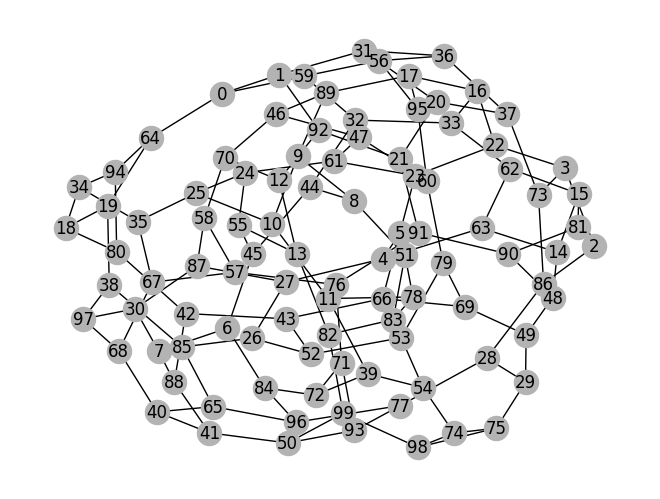

In [9]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [16]:
# Constructs a random d-regular or p-probabilistic graph

datasetItem = {}
for i in range(300):
    p = random.uniform(0,1)
    seed = random.randrange(1, 10, 1)
    nx_graph = generate_graph(n=n, d=d, p=p, graph_type='reg', random_seed=seed)
    # get DGL graph from networkx graph, load onto device
    graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)

    # Construct Q matrix for graph
    q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    datasetItem[i] = [graph_dgl, q_torch, nx_graph]

Generating d-regular graph with n=100, d=3, seed=4
Generating d-regular graph with n=100, d=3, seed=2
Generating d-regular graph with n=100, d=3, seed=9
Generating d-regular graph with n=100, d=3, seed=8
Generating d-regular graph with n=100, d=3, seed=9
Generating d-regular graph with n=100, d=3, seed=8
Generating d-regular graph with n=100, d=3, seed=7
Generating d-regular graph with n=100, d=3, seed=9
Generating d-regular graph with n=100, d=3, seed=8
Generating d-regular graph with n=100, d=3, seed=6
Generating d-regular graph with n=100, d=3, seed=6
Generating d-regular graph with n=100, d=3, seed=8
Generating d-regular graph with n=100, d=3, seed=9
Generating d-regular graph with n=100, d=3, seed=2
Generating d-regular graph with n=100, d=3, seed=6
Generating d-regular graph with n=100, d=3, seed=3
Generating d-regular graph with n=100, d=3, seed=1
Generating d-regular graph with n=100, d=3, seed=6
Generating d-regular graph with n=100, d=3, seed=3
Generating d-regular graph with

In [17]:
datasetItem[1][2].nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99))

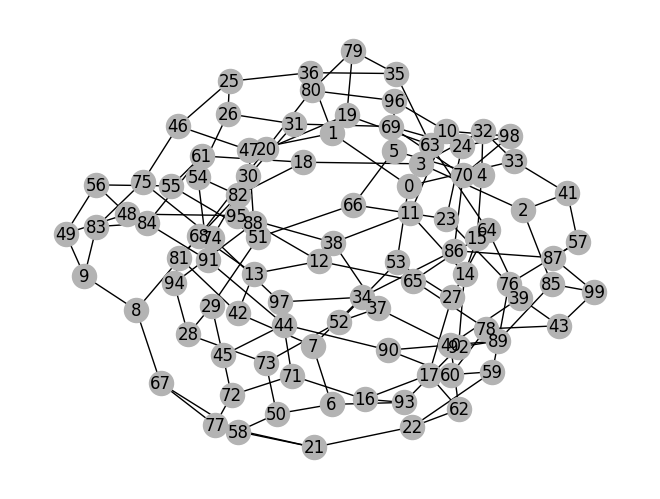

In [18]:
# Visualize graph
pos = nx.kamada_kawai_layout(datasetItem[0][2])
nx.draw(datasetItem[0][2], pos, with_labels=True, node_color=[[.7, .7, .7]])

In [19]:
datasetItem

{0: [Graph(num_nodes=100, num_edges=300,
        ndata_schemes={}
        edata_schemes={}),
  tensor([[-1.,  2.,  0.,  ...,  0.,  0.,  0.],
          [ 0., -1.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0., -1.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ..., -1.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0., -1.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0., -1.]]),
 1: [Graph(num_nodes=100, num_edges=300,
        ndata_schemes={}
        edata_schemes={}),
  tensor([[-1.,  2.,  0.,  ...,  0.,  0.,  0.],
          [ 0., -1.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0., -1.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ..., -1.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0., -1.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0., -1.]]),
 2: [Graph(num_nodes=100, num_edges=300,
        ndata_schemes={}
        edata_schemes={}),
  tensor([[-1.,  2.,  0.,  ...,  0.,  0.,  0.],
          [ 0., -1.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,

# Step 3 - Set up optimizer/GNN architecture

In [20]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

# Step 4 - Run GNN training

In [21]:
print('Running GNN...')
gnn_start = time()

netItem, epoch, final_bitstring, best_bitstring, inputs_item = run_gnn_training(
    datasetItem, net, embed, optimizer, gnn_hypers['number_epochs'],
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: 69.09264373779297
Epoch: 1000, Loss: 35.68435287475586
Epoch: 2000, Loss: 14.403605461120605
Epoch: 3000, Loss: 5.059770584106445
Epoch: 4000, Loss: 1.3236019611358643
Epoch: 5000, Loss: -0.6649268865585327
Epoch: 6000, Loss: -3.768712282180786
Epoch: 7000, Loss: -9.510483741760254
Epoch: 8000, Loss: -20.777040481567383
Epoch: 9000, Loss: -29.605640411376953
Epoch: 10000, Loss: -35.54413604736328
Epoch: 11000, Loss: -38.354881286621094
Epoch: 12000, Loss: -40.26322937011719
Epoch: 13000, Loss: -40.69545364379883
Epoch: 14000, Loss: -40.850311279296875
0: Stopping early on epoch 14106 (patience: 100)
Epoch: 0, Loss: -4.413660049438477
Epoch: 1000, Loss: -23.236820220947266
Epoch: 2000, Loss: -29.440223693847656
Epoch: 3000, Loss: -32.58036804199219
Epoch: 4000, Loss: -33.72220230102539
Epoch: 5000, Loss: -36.34006881713867
Epoch: 6000, Loss: -36.887969970703125
Epoch: 7000, Loss: -37.90949249267578
1: Stopping early on epoch 7101 (patience: 100)
Epoch: 0, 

# Step 5 - Post-process GNN results

In [31]:
p = random.uniform(0,1)
seed = random.randrange(1, 10, 1)
nx_graph = generate_graph(n=n, d=d, p=p, graph_type='reg', random_seed=seed)
# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

netItem.eval()
probs = netItem(graph_dgl, inputs_item)[:, 0]
probs

Generating d-regular graph with n=100, d=3, seed=4


tensor([1.0000e+00, 2.3216e-30, 1.8476e-23, 1.0911e-05, 0.0000e+00, 1.0000e+00,
        2.8689e-13, 1.6756e-09, 0.0000e+00, 1.0000e+00, 1.0000e+00, 2.3586e-38,
        1.0000e+00, 0.0000e+00, 1.3206e-15, 9.9997e-01, 1.0000e+00, 6.9180e-18,
        1.0000e+00, 9.9998e-01, 0.0000e+00, 1.0000e+00, 1.1380e-35, 1.1096e-06,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 1.9669e-36, 2.7259e-34, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 2.5010e-23, 1.0000e+00,
        1.1275e-36, 1.5638e-35, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 3.2339e-17, 1.4884e-14, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        9.9998e-01, 5.0152e-26, 1.0000e+00, 1.1836e-29, 1.0000e+00, 3.3672e-18,
        1.0000e+00, 1.0000e+00, 1.5944e-33, 1.4971e-27, 1.1016e-38, 1.0000e+00,
        0.0000e+00, 7.5666e-26, 2.9759e-20, 0.0000e+00, 9.9998e-01, 0.0000e+00,
        3.2028e-27, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 3.7855e-10, 8.5673e-

In [32]:
final_loss = loss_func(probs.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in probs])

probs = (probs >= 0.5) * 1
final_loss_bit =  (final_loss >= 0.5) * 1
# Process bitstring reported by GNN
size_mis, ind_set, number_violations = postprocess_gnn_mis2(probs, nx_graph)
gnn_tot_time = time() - gnn_start

print(f'Independence number found by GNN is {math.ceil(size_mis)} with {number_violations} violations')
print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

Calculating violations...
861
Independence number found by GNN is 42 with 0 violations
Took 653.595s, model training took 156.894s


In [33]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, nx_number_violations, t_solve = run_mis_solver(nx_graph)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {nx_number_violations} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

Running built-in MIS solver (n=100).
Calculating violations...
Independence number found by nx solver is 38 with 0 violations.
MIS solver took 0.193s


In [ ]:
# Visualize result
# Note no light-blue nodes are connected by an edge
color_map = ['orange' if (probs[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, with_labels=True, node_color=color_map)

# Step 6 - multiple step item

In [65]:
counter = 0
for  i in range (30):
    p = random.uniform(0,1)
    seed = random.randrange(1, 5, 1)
    nx_graph = generate_graph(n=n, d=d, p=p, graph_type='reg', random_seed=seed)
    # get DGL graph from networkx graph, load onto device
    graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)

    # Construct Q matrix for graph
    q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    netItem.eval()
    probs = netItem(graph_dgl, inputs_item)[:, 0]
    final_loss = loss_func(probs.float(), q_torch)
    final_bitstring_str = ','.join([str(x) for x in probs])
    probs = (probs >= 0.5) * 1
    # Process bitstring reported by GNN
    size_mis, ind_set, number_violations = postprocess_gnn_mis(probs, nx_graph)
    gnn_tot_time = time() - gnn_start

    print(f'Independence number found by GNN is {math.ceil(size_mis)} with {number_violations} violations')
    #print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

    # run solver
    print(f'Running built-in MIS solver (n={n}).')
    start = time()
    ind_set_bitstring_nx, ind_set_nx_size, nx_number_violations, t_solve = run_mis_solver(nx_graph)
    end = time()
    runtime_sol = end - start
    print(f'Independence number found by nx solver is {ind_set_nx_size} with {nx_number_violations} violations.')
    print(f'----------------------------------')

    if (math.ceil(size_mis) > ind_set_nx_size):
        counter+=1

print(f'Number of times Neural network output greater than traditional: {counter}')

Generating d-regular graph with n=100, d=3, seed=2
Calculating violations...
Independence number found by GNN is 36 with 0 violations
Running built-in MIS solver (n=100).
Calculating violations...
Independence number found by nx solver is 38 with 0 violations.
----------------------------------
Generating d-regular graph with n=100, d=3, seed=3
Calculating violations...
{(35, 67)}
Independence number found by GNN is 34 with 0 violations
Running built-in MIS solver (n=100).
Calculating violations...
Independence number found by nx solver is 39 with 0 violations.
----------------------------------
Generating d-regular graph with n=100, d=3, seed=4
Calculating violations...
Independence number found by GNN is 42 with 0 violations
Running built-in MIS solver (n=100).
Calculating violations...
Independence number found by nx solver is 38 with 0 violations.
----------------------------------
Generating d-regular graph with n=100, d=3, seed=1
Calculating violations...
{(18, 90), (23, 24)}
{(2

In [97]:
counter = 0
print(n)
for  i in range (10):
    p = random.uniform(0,1)
    seed = random.randrange(1, 5, 1)
    nx_graph = generate_graph(n=n, d=d, p=p, graph_type='reg', random_seed=seed)
    # get DGL graph from networkx graph, load onto device
    graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)

    # Construct Q matrix for graph
    q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    netItem.eval()
    probs = netItem(graph_dgl, inputs_item)[:, 0]
    final_loss = loss_func(probs.float(), q_torch)
    final_bitstring_str = ','.join([str(x) for x in probs])
    probs = (probs <= 0.5) * 1

    # Process bitstring reported by GNN
    size_mis, ind_set, number_violations = postprocess_gnn_mis(probs, nx_graph)
    gnn_tot_time = time() - gnn_start

    print(f'Independence number found by GNN is {math.ceil(size_mis)} with {number_violations} violations')
    #print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

    # run solver
    print(f'Running built-in MIS solver (n={n}).')
    start = time()
    ind_set_bitstring_nx, ind_set_nx_size, nx_number_violations, t_solve = run_mis_solver(nx_graph)
    end = time()
    runtime_sol = end - start
    print(f'Independence number found by nx solver is {ind_set_nx_size} with {nx_number_violations} violations.')
    print(f'----------------------------------')

    if (math.ceil(size_mis) > ind_set_nx_size):
        counter+=1

print(f'Number of times Neural network output greater than traditional: {counter}')

100
Generating d-regular graph with n=100, d=3, seed=4
Calculating violations...
Independence number found by GNN is 58 with 0 violations
Running built-in MIS solver (n=100).
Calculating violations...
Independence number found by nx solver is 38 with 0 violations.
----------------------------------
Generating d-regular graph with n=100, d=3, seed=4
Calculating violations...
Independence number found by GNN is 58 with 0 violations
Running built-in MIS solver (n=100).
Calculating violations...
Independence number found by nx solver is 38 with 0 violations.
----------------------------------
Generating d-regular graph with n=100, d=3, seed=2
Calculating violations...
Independence number found by GNN is 64 with 0 violations
Running built-in MIS solver (n=100).
Calculating violations...
Independence number found by nx solver is 38 with 0 violations.
----------------------------------
Generating d-regular graph with n=100, d=3, seed=3
Calculating violations...
Independence number found by GN